In [12]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from scipy.integrate import solve_ivp

In [13]:
import json

# Nav_params = {
#         "C1C2b2": 0.8,
#         "C1C2v2": -21,
#         "C1C2k2": -9,
        
#         "C2C1b1": 0.05,
#         "C2C1v1": -56,
#         "C2C1k1": 10,
#         "C2C1b2": 0.8,
#         "C2C1v2": -21,
#         "C2C1k2": -9,

#         "C2O1b2": 0.8,
#         "C2O1v2": -61,
#         "C2O1k2": -9,
        
#         "O1C2b1": 0.5,
#         "O1C2v1": -96,
#         "O1C2k1": 10,
#         "O1C2b2": 0.8,
#         "O1C2v2": -61,
#         "O1C2k2": -9,
        
#         "C2O2b2": 0.0001,
#         "C2O2v2": -5,
#         "C2O2k2": -8,
        
#         "O2C2b1": 0.0001,
#         "O2C2v1": -65,
#         "O2C2k1": 7,
#         "O2C2b2": 0.0001,
#         "O2C2v2": -15,
#         "O2C2k2": -12,
        
#         "O1I1b1": 0.04,
#         "O1I1v1": -59,
#         "O1I1k1": 8,
#         "O1I1b2": 0.8,
#         "O1I1v2": 1,
#         "O1I1k2": -10,
        
#         "I1O1b1": 0.0001,
#         "I1O1v1": -60,
#         "I1O1k1": 8,
        
#         "I1C1b1": 0.06,
#         "I1C1v1": -59,
#         "I1C1k1": 8,
        
#         "C1I1b2": 0.04,
#         "C1I1v2": -59,
#         "C1I1k2": -8,
        
#         "I1I2b2": 0.0016,
#         "I1I2v2": -60,
#         "I1I2k2": -20,
#         "I2I1b1": 0.0115,
#         "I2I1v1": -100,
#         "I2I1k1": 8

#     }

# with open('Nav19.json', 'w') as json_file:
#     json.dump(Nav_params, json_file)



Nav_type = "Nav19"

with open(f'Nav\\{Nav_type}.json') as json_file:
    Nav_params = json.load(json_file)



C:\Users\niels\AppData\Local\Temp\ipykernel_29532\611146932.py:14: RuntimeWarning: invalid value encountered in divide
  am = 0.1 * (25 - V) / (np.exp((25 - V) / 10) - 1)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


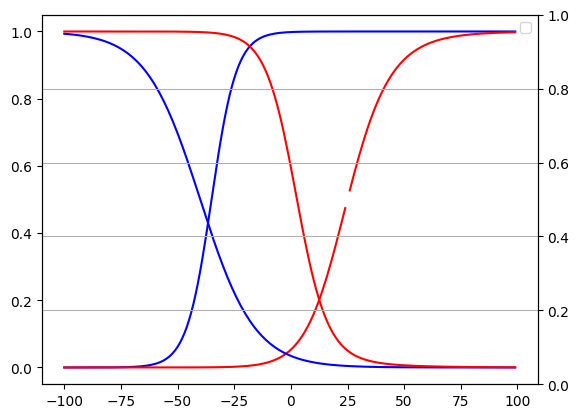

In [14]:

def Nav1_1(V):
    """Goal:
        NaV1.1 channel model from the paper ......"""
    mInf_Nav1_1 = 1/(1+np.exp(-(V - -35) / 5.5))
    hInf_Nav1_1 = 1/(1+np.exp((V - -40) / 12))

    if V < -50:
        mtau_Nav1_1 = 0.006 + 0.08 * (1 / (1 + np.exp(-(V - -55) / 12)))
    else:
        mtau_Nav1_1 = 0.015 + 0.065 * (1 / (1 + np.exp((V - -10.8) / 10)))
    return mInf_Nav1_1, hInf_Nav1_1, mtau_Nav1_1

def Na(V):
    am = 0.1 * (25 - V) / (np.exp((25 - V) / 10) - 1)
    bm = 4 * np.exp(-V / 18)

    ah = 0.07 * np.exp(-V / 20)
    bh = 1 / (np.exp((30 - V) / 10) + 1)

    return am / (am + bm), ah / (ah + bh), 1 / (am + bm)

V = np.arange(-100, 100, 1)

mInf_Nav1_1, hInf_Nav1_1, mtau_Nav1_1 = [], [], []
for v in V:
    mInf, hInf, mtau = Nav1_1(v)
    mInf_Nav1_1.append(mInf)
    hInf_Nav1_1.append(hInf)
    mtau_Nav1_1.append(mtau)

mInf_Na, hInf_Na, mtau_Na = Na(V)

fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(V, mInf_Nav1_1, label='mInf_Nav1_1',  color='blue')
ax.plot(V, mInf_Na, label='mInf_Na', color='red')
ax.plot(V, hInf_Nav1_1, label='hInf_Nav1_1', color='blue')
ax.plot(V, hInf_Na, label='hInf_Na', color='red')
plt.legend()
plt.grid()
plt.show()


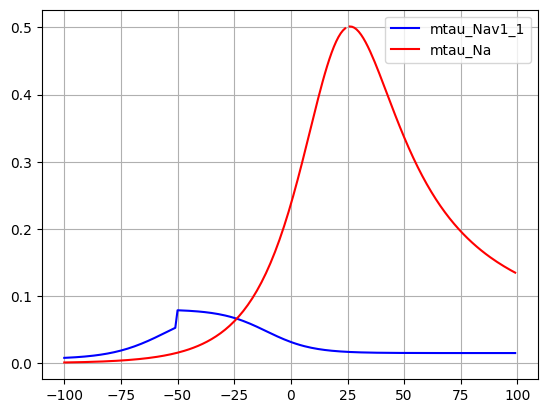

In [15]:
plt.plot(V, mtau_Nav1_1, label='mtau_Nav1_1', color='blue')
plt.plot(V, mtau_Na, label='mtau_Na', color='red')
plt.legend()
plt.grid()
plt.show()

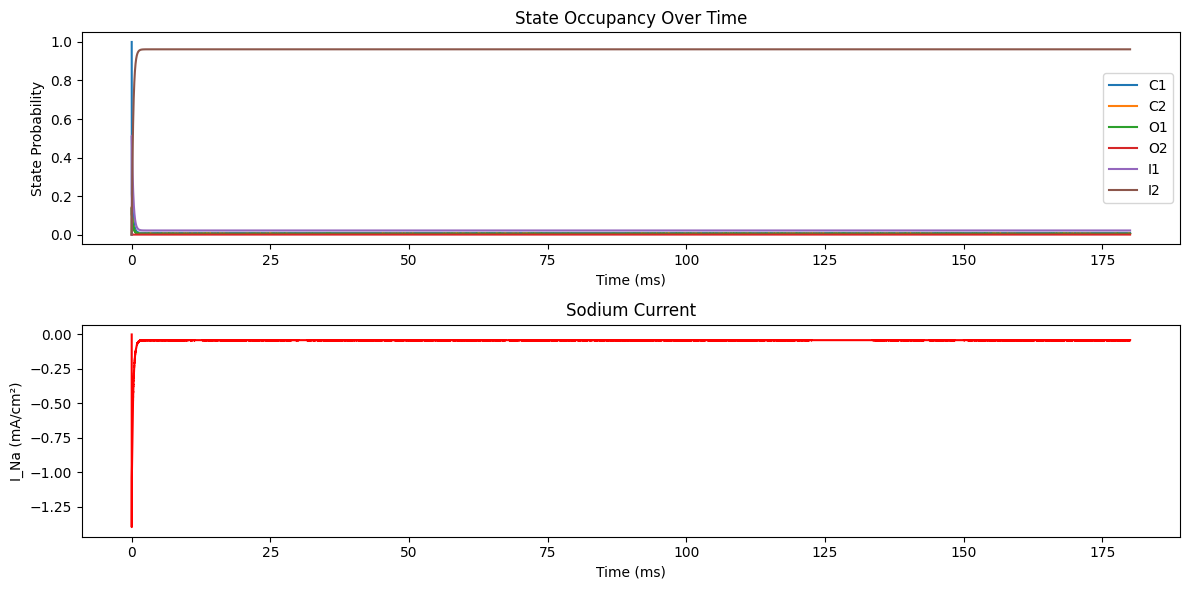

In [17]:


# Constants
celsius = 37  # Temperature in degrees Celsius
Q10 = 3 ** ((celsius - 20) / 10)  # Temperature scaling factor

# Channel properties
gbar = 0.1  # Max conductance (mho/cm²)
ena = 50    # Reversal potential for sodium (mV)

# Define the transition rates
@njit(fastmath = True)
def Nav_channel(v, y):
    """Goal:
        Derivatives for the Nav channels 1-9.
    --------------------------------------------------------------------
    Input:
        v: Voltage [mV]
        y: States
    --------------------------------------------------------------------
    Output:
        dydt: Derivative of the states
    """
    # Define the rates and sum some of them
    rates_raw = Q10 * bs / (1 + np.exp((v - vvs) / ks))
    rates = rates_raw[np.array([0, 1, 3, 4, 6, 7, 9, 11, 12, 13, 14, 15])].copy()
    rates[np.array([1, 3, 5, 6])] += rates_raw[np.array([2, 5, 8, 10])]

    # Create the transition matrix
    Q = np.zeros((6, 6))
    Q[0, 0] = -(rates[0] + rates[9])
    Q[0, 1] = rates[1]
    Q[0, 4] = rates[8]
    Q[1, 0] = rates[0]
    Q[1, 1] = -(rates[1] + rates[2] + rates[4])
    Q[1, 2] = rates[3]
    Q[1, 3] = rates[5]
    Q[2, 1] = rates[2]
    Q[2, 2] = -(rates[3] + rates[6])
    Q[2, 4] = rates[7]
    Q[3, 1] = rates[4]
    Q[3, 3] = -rates[5]
    Q[4, 0] = rates[9]
    Q[4, 2] = rates[6]
    Q[4, 4] = -(rates[8] + rates[7] + rates[10])
    Q[4, 5] = rates[11]
    Q[5, 4] = rates[10]
    Q[5, 5] = -rates[11]

    return (Q @ y) * 1000

def markov_model(t, y, v):
    """"
    Goal:
        Markov model for the Nav channels 1-9.
    --------------------------------------------------------------------
    Input:
        t: time
        y: States
        v: Voltage [mV]
    --------------------------------------------------------------------
    Output:
        dydt: Derivative of the states
    """
    dydt = Nav_channel(v, y)
    return dydt

Nav_params = Nav_params

# ---- Initialize Parameters ----
bs = np.array(
    [
        Nav_params["C1C2b2"], 
        Nav_params["C2C1b1"], Nav_params["C2C1b2"], 
        Nav_params["C2O1b2"],
        Nav_params["O1C2b1"], Nav_params["O1C2b2"], 
        Nav_params["C2O2b2"], 
        Nav_params["O2C2b1"], Nav_params["O2C2b2"], 
        Nav_params["O1I1b1"], Nav_params["O1I1b2"], 
        Nav_params["I1O1b1"],
        Nav_params["I1C1b1"], 
        Nav_params["C1I1b2"], 
        Nav_params["I1I2b2"], 
        Nav_params["I2I1b1"]
    ], dtype = np.float64
    )

vvs = np.array(
    [
        Nav_params["C1C2v2"], 
        Nav_params["C2C1v1"], Nav_params["C2C1v2"], 
        Nav_params["C2O1v2"],
        Nav_params["O1C2v1"], Nav_params["O1C2v2"], 
        Nav_params["C2O2v2"], 
        Nav_params["O2C2v1"], Nav_params["O2C2v2"], 
        Nav_params["O1I1v1"], Nav_params["O1I1v2"], 
        Nav_params["I1O1v1"],
        Nav_params["I1C1v1"], 
        Nav_params["C1I1v2"], 
        Nav_params["I1I2v2"], 
        Nav_params["I2I1v1"]
    ], dtype = np.float64
    )

ks = np.array(
    [
        Nav_params["C1C2k2"],
        Nav_params["C2C1k1"], Nav_params["C2C1k2"], 
        Nav_params["C2O1k2"],
        Nav_params["O1C2k1"], Nav_params["O1C2k2"], 
        Nav_params["C2O2k2"],
        Nav_params["O2C2k1"], Nav_params["O2C2k2"], 
        Nav_params["O1I1k1"], Nav_params["O1I1k2"], 
        Nav_params["I1O1k1"],
        Nav_params["I1C1k1"],
        Nav_params["C1I1k2"],
        Nav_params["I1I2k2"],
        Nav_params["I2I1k1"]
    ], dtype = np.float64
    )





# Initial state (all in closed state C1)
y0 = [1, 0, 0, 0, 0, 0]

# Voltage step protocol
v_step = -50  # Membrane potential in mV

# Time span
t_span = (0, 180)  # 50 ms
t_eval = np.arange(0, 180, 0.0001)

# Solve ODEs
sol = solve_ivp(markov_model, t_span, y0, args=(v_step,), t_eval=t_eval, method='RK45')

# Compute conductance and current
g = gbar * (sol.y[2] + sol.y[3])  # g = gbar * (O1 + O2)
ina = g * (v_step - ena)  # I_Na = g * (V - E_Na)

# Plot results
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(sol.t, sol.y[0], label="C1")
plt.plot(sol.t, sol.y[1], label="C2")
plt.plot(sol.t, sol.y[2], label="O1")
plt.plot(sol.t, sol.y[3], label="O2")
plt.plot(sol.t, sol.y[4], label="I1")
plt.plot(sol.t, sol.y[5], label="I2")
plt.xlabel("Time (ms)")
plt.ylabel("State Probability")
plt.title("State Occupancy Over Time")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(sol.t, ina, color='r')
plt.xlabel("Time (s)")
plt.ylabel("I_Na (mA/cm²)")
plt.title("Sodium Current")

plt.tight_layout()
plt.show()


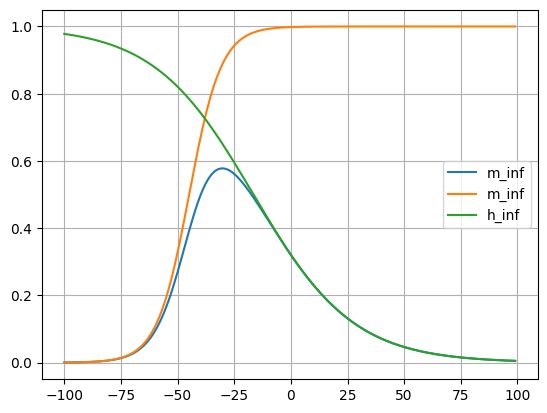

In [13]:
import numpy as np
import matplotlib.pyplot as plt
vm5 = -44.9
km = 7.1
vh5 = -16.5
kh = -22

def m_inf(v):
    return 1 / (1 + np.exp(-(v - vm5) / km))

def h_inf(v):
    return 1 / (1 + np.exp(-(v - vh5) / kh))

v = np.arange(-100, 100, 1)
m_inf_values = m_inf(v)
h_inf_values = h_inf(v)

plt.plot(v, m_inf_values * h_inf_values, label='m_inf')

plt.plot(v, m_inf_values, label='m_inf')
plt.plot(v, h_inf_values, label='h_inf')
plt.legend()
plt.grid()
plt.show()


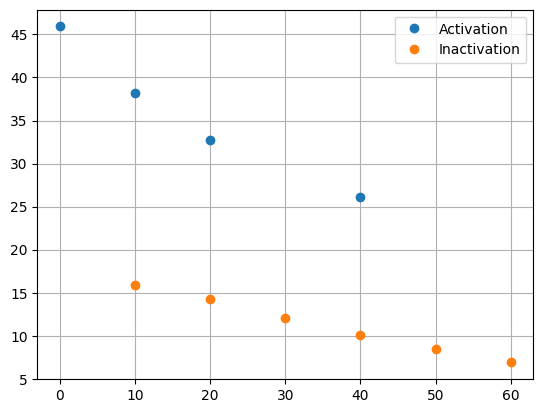

In [12]:
time_act = np.array(
            [
                [0, 45.92529466076125],
                [10, 38.199772693840195],
                [20, 32.72746468349254],
                [40, 26.121530773786215]
            ]
        )

time_inact = np.array(
            [
                [10, 15.936611293876526],
                [20, 14.221500815771678],
                [30, 12.064709219432176],
                [40, 10.055321941997391],
                [50, 8.444458470009652],
                [60, 6.896991905005629]
            ]
        )

plt.plot(time_act[:, 0], time_act[:, 1], "o", label = "Activation")
plt.plot(time_inact[:, 0], time_inact[:, 1], "o", label = "Inactivation")
plt.grid()
plt.legend()
plt.show()

C:\Users\niels\AppData\Local\Temp\ipykernel_36084\2805924099.py:54: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  return Q @ y
C:\Users\niels\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numba\core\typing\npydecl.py:913: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))


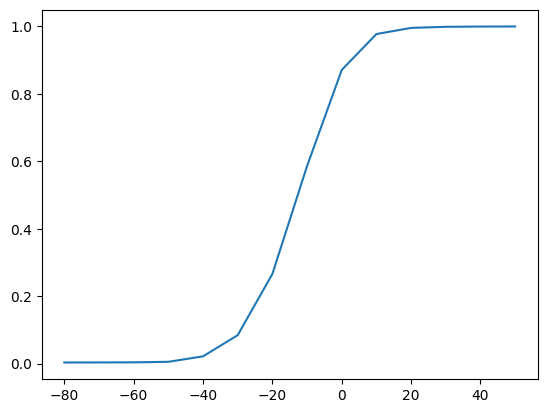

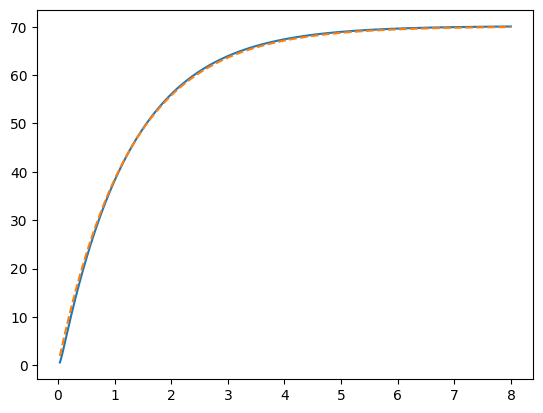

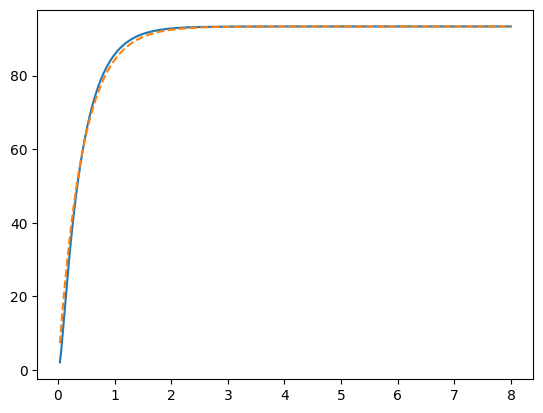

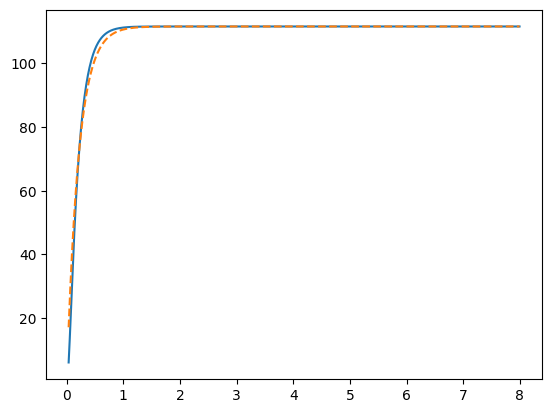

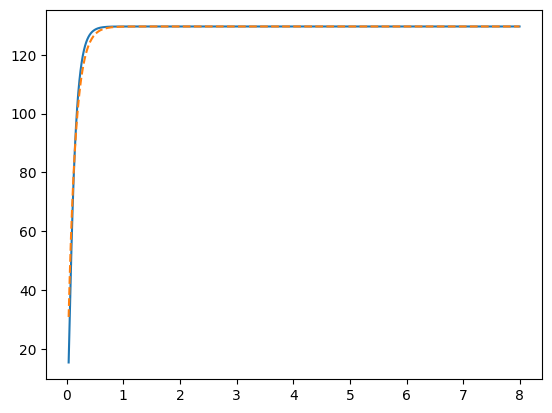

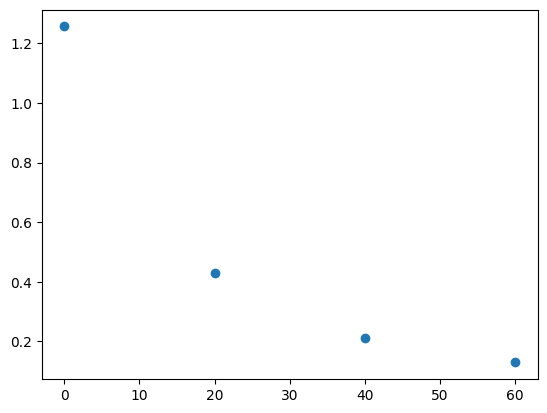

In [ ]:
from numba import njit
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit

@njit(fastmath = True)
def transition_matrix(Vm):
    C1C2 = 0.0069 * np.exp(0.0272 * Vm) # a0
    C2C1 = 0.0227 * np.exp(-0.0431 * Vm) # b0
    C3O = 0.0218 * np.exp(0.0262 * Vm) # a1
    OC3 = 0.0009 * np.exp(-0.0269 * Vm) # b1
    OI = 0.0622 * np.exp(0.0120 * Vm) # ai
    IO = 0.0059 * np.exp(-0.0443 * Vm) # bi
    C2C3 = 0.0266 # kf
    C3C2 = 0.1348 # kb
    C3I = 1.29E-5 * np.exp(2.71E-6 * Vm) # ai3
    IC3 = (OC3 * IO * C3I) / (C3O * OI) # Greek letter


    Q = np.zeros((5, 5))
    Q[0, 0] = -C1C2 # C1
    Q[0, 1] = C2C1
    Q[1, 0] = C1C2 # C2
    Q[1, 1] = -(C2C1 + C2C3)
    Q[1, 2] = C3C2
    Q[2, 2] = -(C3C2 + C3O + C3I) # C3
    Q[2, 1] = C2C3
    Q[2, 3] = OC3
    Q[2, 4] = IC3
    Q[3, 3] = -(OC3 + OI) # O
    Q[3, 2] = C3O
    Q[3, 4] = IO
    Q[4, 4] = -(IO + IC3) # I
    Q[4, 2] = C3I 
    Q[4, 3] = OI
    

    return Q * 1000 # ms^-1 to s^-1


def steady_state(Vm):
    Q = transition_matrix(Vm)
    # One formula is adapted as the sum of probabilities should be 1
    Q[-1, :] = 1
    # Solve the linear system
    b = np.array([0, 0, 0, 0, 1])
    steady_state = np.linalg.solve(Q, b)
    return steady_state

@njit(fastmath = True)
def kv11(t, y, Vm):
    Q = transition_matrix(Vm)
    return Q @ y


# # def fit_kv11():
# Vs = np.arange(-100, 100, 1)
# y0s = []
# for Vm in Vs:
#     y0s.append(steady_state(Vm))
# y0s = np.array(y0s)

# plt.plot(Vs, y0s, label = ["C1", "C2", "C3", "O", "I"])
# # plt.plot(v, m_inf_values * h_inf_values, "--", label='m_inf')
# plt.legend()
# plt.grid()
# plt.show()

# plt.plot(Vs, y0s[:, 3] * (Vs - -84.3))
# plt.show()

# ----- Protocol to measure the peak tail current -----
# Time span
t_span = (0, 3.5)  # 50 ms
t_eval = np.arange(0, 3.5, 0.0001)
Vm2 = -50
t_span2 = (0, 0.5)
t_eval2 = np.arange(0, 0.5, 0.0001)


peak_tail_currents = []
voltages = np.arange(-80, 60, 10) 
for Vm in voltages:
    # Solve ODEs
    y0 = steady_state(-80)
    sol = solve_ivp(kv11, t_span, y0, args=(Vm,), t_eval=t_eval, method='RK45')
    sol = solve_ivp(kv11, t_span2, sol.y[:, -1], args=(Vm2,), t_eval=t_eval2, method='RK45')
    peak_tail_currents.append(max(sol.y[3, :] * (Vm2 - -82)))

plt.plot(voltages, peak_tail_currents / max(peak_tail_currents))
plt.show()

activation_measurements = {}
# ----- Protocol to measure activation kinetics -----
y0 = steady_state(-80)
for Vm in np.arange(0, 61, 20):
    activation_measurements[Vm] = []
    for duration in np.arange(0.035, 8, 0.01):
        # Solve ODEs
        sol = solve_ivp(kv11, (0, duration), y0, args=(Vm,), t_eval=np.arange(0, duration, 0.0001), method='RK45')
        sol = solve_ivp(kv11, (0, 0.2), sol.y[:, -1], args=(-120,), t_eval=np.arange(0, 0.2, 0.0001), method='RK45')
        activation_measurements[Vm].append(max(sol.y[3, :] * (Vm - -82)))


def fit_act(duration , tau, peak_tail_currents):
    return peak_tail_currents * (1 - np.exp(-duration / tau))

tau_acts = []
for Vm, currents in activation_measurements.items():
    # Fit model
    popt, _ = curve_fit(
        lambda x, tau: fit_act(x, tau, max(currents)), 
        np.arange(0.035, 8, 0.01), 
        currents, 
        p0 = [0.1]
        )
    plt.plot(np.arange(0.035, 8, 0.01), currents, label = f"{Vm} mV")
    plt.plot(np.arange(0.035, 8, 0.01), 
             fit_act(np.arange(0.035, 8, 0.01), *popt, max(currents)), "--")
    plt.show()
    #popt, _ = curve_fit(fit_act, np.arange(0.035, 0.49, 0.01), currents, p0 = [0.1, max(currents)])
    tau_acts.append(popt[0])

    # plt.plot(np.arange(0, 60, 20), normalized_currents, label = f"{duration} s")
    # plt.legend()
    # plt.show()

    # fit Itail(t) = Itailmax * (1 - exp(-t/tau))

plt.plot(np.arange(0, 61, 20), tau_acts, "o")
plt.show()